In [61]:
import torch
from IPython import display
from d2l import torch as d2l

batch_size = 256
train_iter,test_iter = d2l.load_data_fashion_mnist(batch_size)

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size):
这是数据准备的核心步骤。d2l.load_data_fashion_mnist 是一个高级封装函数，它在幕后完成了多项工作：
下载数据集: 如果本地没有 Fashion-MNIST 数据集，它会自动从网上下载。
数据预处理: 它会将图像数据从原始的 PIL 图像格式或 NumPy 数组转换为 PyTorch 的 Tensor 格式。同时，它会将像素值从 [0, 255] 的整数范围归一化到 [0, 1] 的浮点数范围，这是神经网络训练的标准实践。
创建数据迭代器 (Data Loader): 函数返回两个对象：train_iter 和 test_iter。它们是 PyTorch DataLoader 的实例，可以看作是高效的数据管道。当我们从 train_iter 中请求数据时，它会按顺序（或随机打乱后）吐出一个包含 batch_size (256) 个图像张量和对应标签张量的批次。test_iter 的功能类似，但用于测试数据集。

In [62]:
num_inputs = 784
num_outputs = 10
#输出维度
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

全连接层的输入必须是一维的，因此需要进行展平

In [63]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [64]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # 这里应用了广播机制

In [65]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.0876, 0.2692, 0.5243, 0.0785, 0.0404],
         [0.0970, 0.0651, 0.0993, 0.7041, 0.0346]]),
 tensor([1., 1.]))

In [66]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

In [67]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [68]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

In [69]:
def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y  #进行类型转换确保健壮
    return float(cmp.type(y.dtype).sum())

cmp为布尔类型的张量，最后转换为数值类型并求和，从而得到的数就是总共正确的数量

准确率是作为评估（给人看的）
而交叉熵作为损失函数是给机器看的，需要可微（能够反向传播）

In [70]:
accuracy(y_hat, y) / len(y)

0.5

In [71]:
def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

net.eval(): 这是非常关键的一步。 它将模型切换到“评估模式”（Evaluation Mode）。这会影响一些在训练和预测时行为不同的层，主要是：
Dropout 层: 在评估模式下会被禁用。如果在评估时还随机丢弃神经元，会导致结果不稳定且偏低。
BatchNorm (批量归一化) 层: 在评估模式下，它会使用在整个训练过程中学习到的均值和方差，而不是使用当前批次数据的均值和方差。这保证了评估结果的一致性。
总之，不调用 net.eval() 会导致评估结果不准确、不可复现，是一个常见的错误。

with torch.no_grad():: 这是另一个至关重要的步骤。 它创建了一个上下文管理器，在该代码块中，PyTorch 将不会计算梯度。
为什么需要它？
提升性能: 在模型评估时，我们只进行前向传播（Forward Pass），不需要计算梯度来进行反向传播和参数更新。关闭梯度计算可以大大减少内存消耗和计算时间，让评估过程更快。
保证正确性: 它明确告诉框架，这里的操作不应影响模型的梯度状态。

In [72]:
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [73]:
evaluate_accuracy(net, test_iter)

0.1136

In [74]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()# 清除上一批次计算得到的梯度。这是一个必须的步骤，因为梯度是会累加的。
            l.mean().backward() #反向传播
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            '''这里使用 .sum() 是因为我们自定义的损失函数可能返回每个样本的损失，需要将它们加起来计算总的梯度。'''
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [75]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


In [76]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [77]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

In [78]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

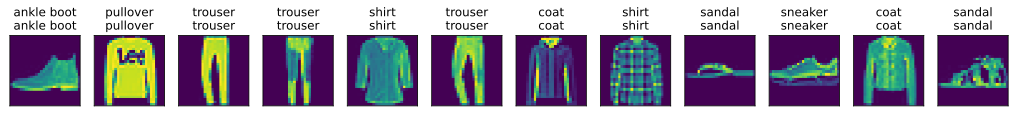

In [79]:
def predict_ch3(net, test_iter, n=12):  #@save
    """预测标签（定义见第3章）"""

    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)